In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import os

In [2]:
# Merging the returns data for all stocks into one CSV file

sectors = ["AUTO", "BANK", "FMCG", "IT", "METAL", "PHARMA"]
merged_df = None

for sector in sectors:
    folder_path = f"STOCKS_NSE_{sector}"
    
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, usecols=["Date", "Returns"])
            df["Date"] = pd.to_datetime(df["Date"])
            stock_name = file.replace(".NS_historical_data.csv", "")
            df.rename(columns={"Returns": stock_name}, inplace=True)
            
            merged_df = df if merged_df is None else pd.merge(merged_df, df, on="Date", how="inner")

# Sorting and cleaning up the final DataFrame
if merged_df is not None:
    merged_df.dropna(inplace=True)
    merged_df.sort_values(by="Date", inplace=True)
    merged_df.to_csv("merged_stock_returns.csv", index=False)
    print("Merged CSV saved as 'merged_stock_returns.csv'")


Merged CSV saved as 'merged_stock_returns.csv'


In [3]:
risk_free_rate = 0.07  # Assuming a 7% annual risk-free rate

def calculate_ratios(stock_returns):
    """Calculate Sharpe Ratio, Sortino Ratio, and Maximum Drawdown for a given stock's returns."""
    
    mean_return = stock_returns.mean() * 252
    std_dev = stock_returns.std() * np.sqrt(252)
    
    # Sharpe Ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan

    # Sortino Ratio (only considers negative returns)
    downside_risk = stock_returns[stock_returns < 0].std() * np.sqrt(252)
    sortino_ratio = (mean_return - risk_free_rate) / downside_risk if downside_risk != 0 else np.nan

    # Maximum Drawdown
    cumulative_returns = (1 + stock_returns).cumprod()
    peak = cumulative_returns.cummax()
    max_drawdown = ((cumulative_returns - peak) / peak).min()

    return sharpe_ratio, sortino_ratio, max_drawdown


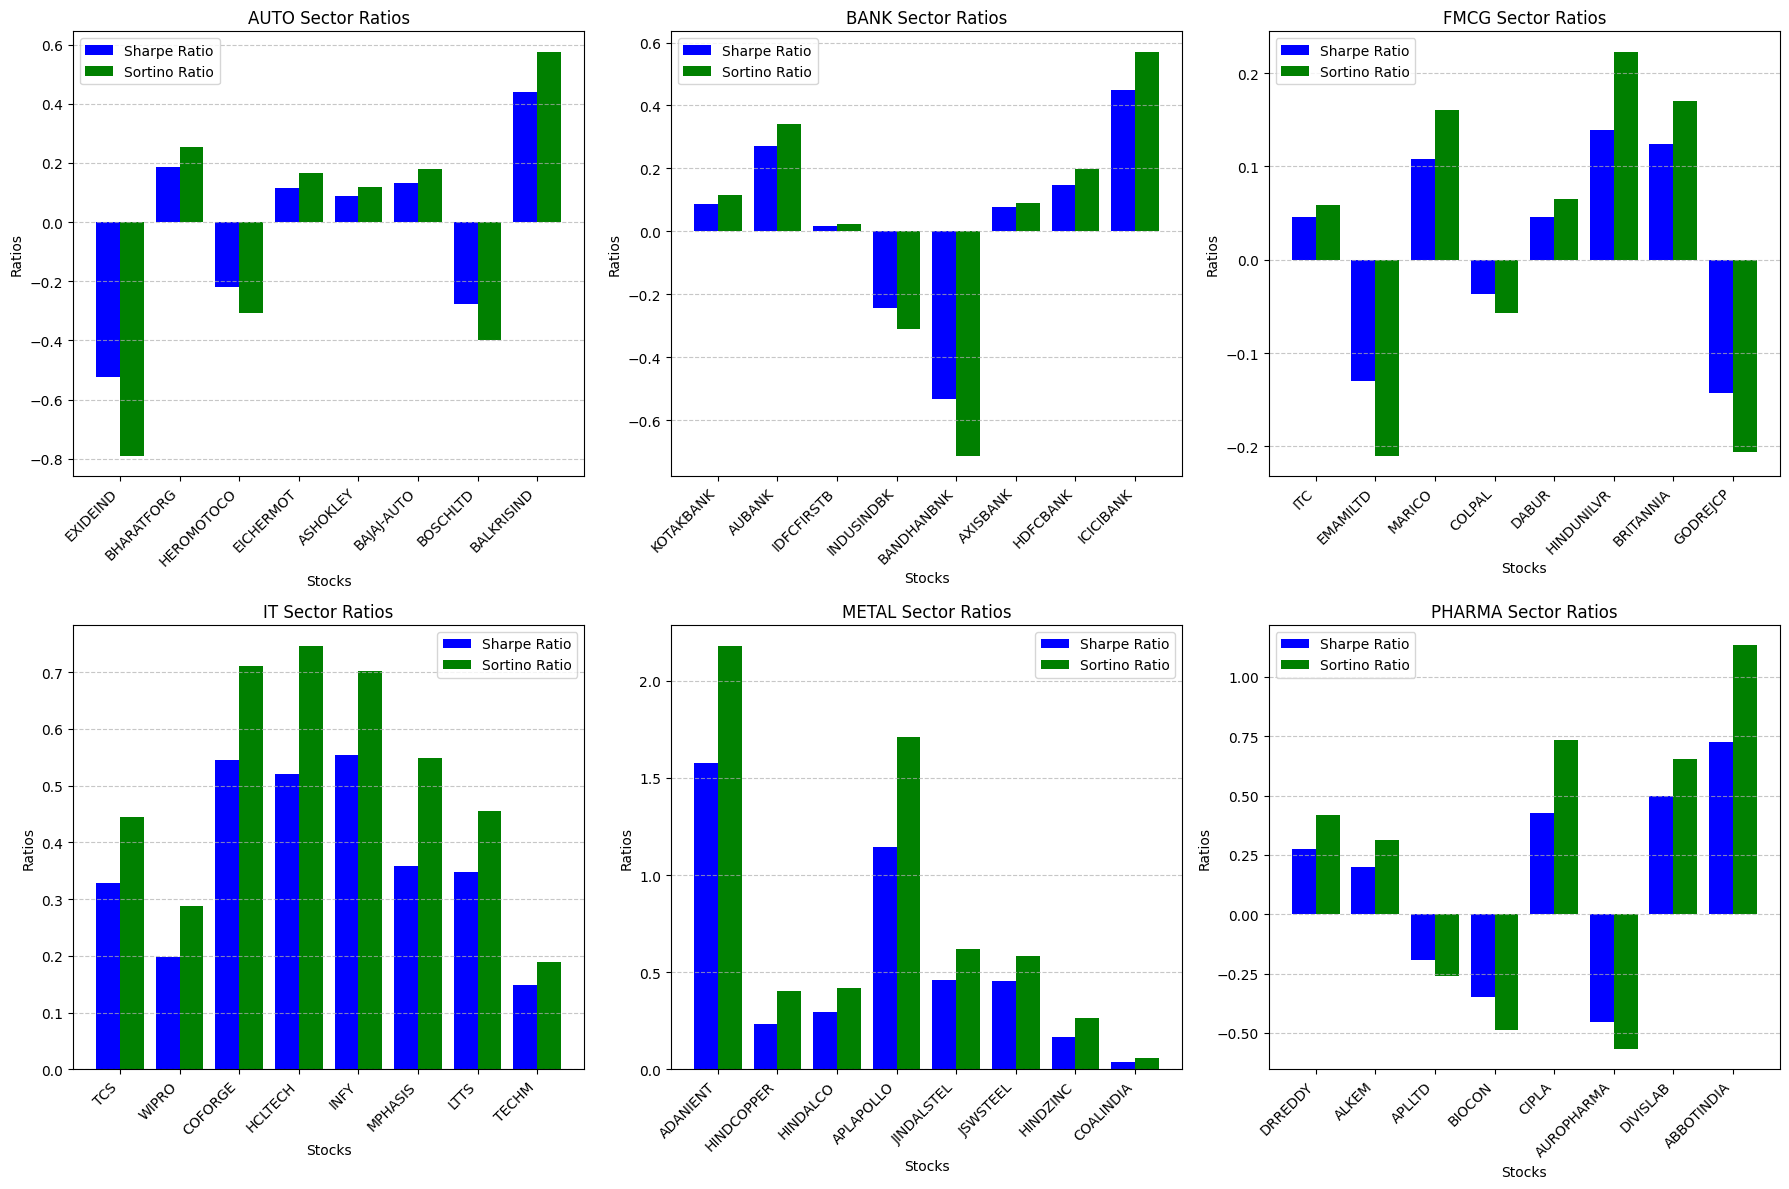

In [4]:
# Load returns data
returns = pd.read_csv("merged_stock_returns.csv", index_col=0).dropna(how="any")

# Create sector map
sector_map = {
    file.replace(".NS_historical_data.csv", ""): sector
    for sector in sectors
    for file in os.listdir(f"STOCKS_NSE_{sector}") if file.endswith(".csv")
}

# Calculate ratios for each stock and organize by sector
sector_ratios = {}

for sector in sectors:
    sector_stocks = [stock for stock in returns.columns if sector_map.get(stock) == sector]
    
    if not sector_stocks:
        continue  # Skip sector if no stocks found
    
    sector_returns = returns[sector_stocks]
    
    # Compute ratios
    ratios = {
        stock: calculate_ratios(sector_returns[stock])
        for stock in sector_stocks
    }

    # Convert to DataFrame
    sector_ratios[sector] = pd.DataFrame(ratios, index=["Sharpe Ratio", "Sortino Ratio", "Maximum Drawdown"]).T

# Set up a grid layout for all plots
num_sectors = len(sector_ratios)
cols = 3  # Number of columns in the grid
rows = -(-num_sectors // cols)  # Ceiling division for rows

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()  # Flatten in case of a single row

for i, (sector, metrics) in enumerate(sector_ratios.items()):
    ax = axes[i]
    x = np.arange(len(metrics))
    bar_width = 0.4
    
    ax.bar(x - bar_width / 2, metrics["Sharpe Ratio"], bar_width, label="Sharpe Ratio", color="blue")
    ax.bar(x + bar_width / 2, metrics["Sortino Ratio"], bar_width, label="Sortino Ratio", color="green")
    
    ax.set_xticks(x)
    ax.set_xticklabels(metrics.index, rotation=45, ha="right")
    ax.set_title(f"{sector} Sector Ratios")
    ax.set_xlabel("Stocks")
    ax.set_ylabel("Ratios")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/var/folders/0q/q8psjl3j08qcv0t1zg8mkw100000gn/T/ipykernel_82200/521075021.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


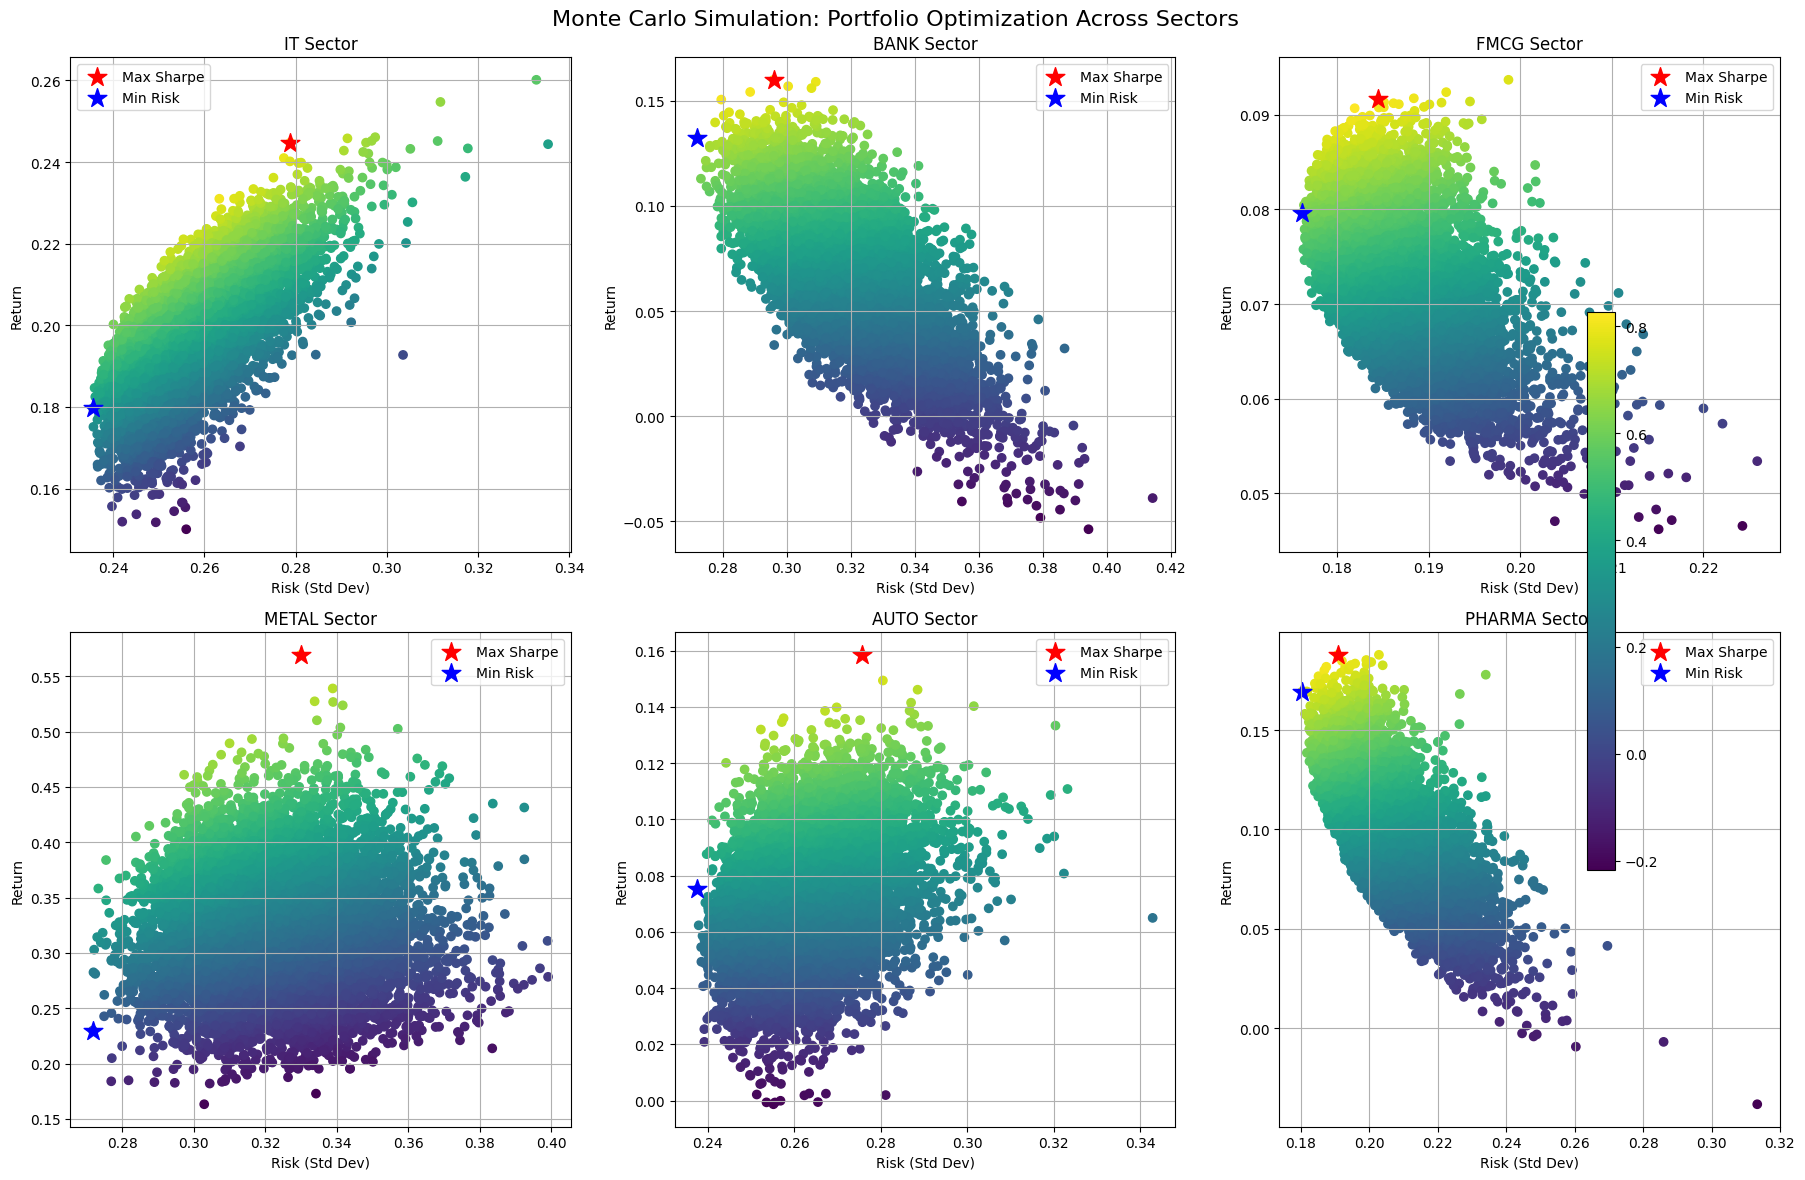

In [5]:
# Running Monte Carlo Simulations for each sector and build a portfolio seperately for a better understanding
# Load returns data
returns = pd.read_csv("merged_stock_returns.csv", index_col=0).dropna(how="any")

# Group stocks by sector
sector_stocks = {sector: [] for sector in set(sector_map.values())}
for stock, sector in sector_map.items():
    sector_stocks[sector].append(stock)

# Monte Carlo simulation function
def monte_carlo_simulation(sector, returns, num_portfolios=10000, risk_free_rate=0.03):
    stocks = sector_stocks[sector]
    sector_returns = returns[stocks].dropna()
    mu = (np.exp(sector_returns.mean()) - 1) * 252
    Sigma = sector_returns.cov() * 252

    results = np.zeros((num_portfolios, 3))

    for i in range(num_portfolios):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)

        portfolio_return = np.dot(weights, mu)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(Sigma.values, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk

        results[i] = [portfolio_risk, portfolio_return, sharpe_ratio]

    results_df = pd.DataFrame(results, columns=["Risk", "Return", "Sharpe Ratio"])
    max_sharpe = results_df.loc[results_df["Sharpe Ratio"].idxmax()]
    min_risk = results_df.loc[results_df["Risk"].idxmin()]

    return results_df, max_sharpe, min_risk

# Run simulations for each sector
sector_results = {sector: monte_carlo_simulation(sector, returns) for sector in sector_stocks}

# Plot settings
num_sectors = len(sector_results)
cols = 3  # Number of columns in the grid
rows = -(-num_sectors // cols)  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
fig.suptitle("Monte Carlo Simulation: Portfolio Optimization Across Sectors", fontsize=16)

for i, (sector, (results_df, max_sharpe, min_risk)) in enumerate(sector_results.items()):
    ax = axes[i // cols, i % cols]
    
    # Scatter plot
    scatter = ax.scatter(results_df["Risk"], results_df["Return"], c=results_df["Sharpe Ratio"], cmap="viridis", marker="o")
    ax.scatter(max_sharpe["Risk"], max_sharpe["Return"], color="r", marker="*", s=200, label="Max Sharpe")
    ax.scatter(min_risk["Risk"], min_risk["Return"], color="b", marker="*", s=200, label="Min Risk")
    
    ax.set_title(f"{sector} Sector")
    ax.set_xlabel("Risk (Std Dev)")
    ax.set_ylabel("Return")
    ax.legend()
    ax.grid()

# Adjust layout and add color bar
plt.colorbar(scatter, ax=axes, fraction=0.02, pad=0.02)
plt.tight_layout()
plt.show()

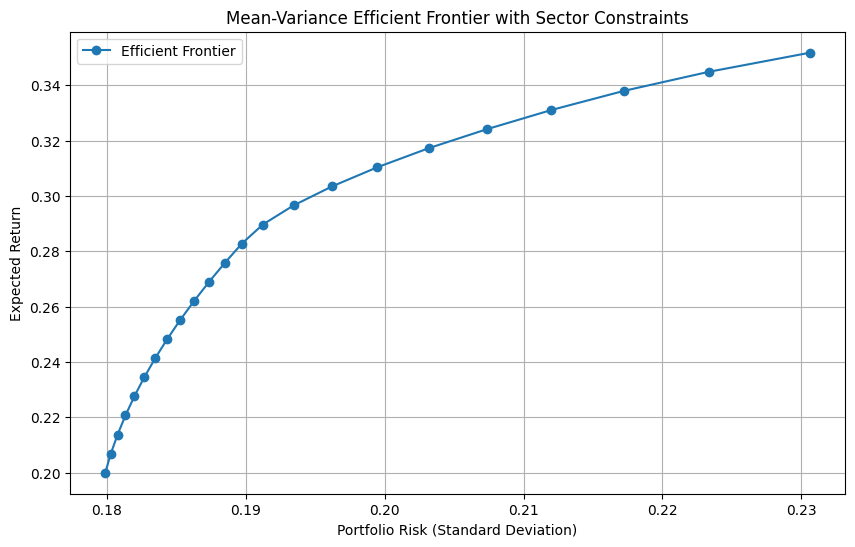

Optimal Portfolio for 20% target return: 
BALKRISIND: 0.0264
BAJAJ-AUTO: 0.1736
HDFCBANK: 0.1366
HINDUNILVR: 0.2000
INFY: 0.0949
HCLTECH: 0.1051
ADANIENT: 0.0119
APLAPOLLO: 0.0515
ABBOTINDIA: 0.2000


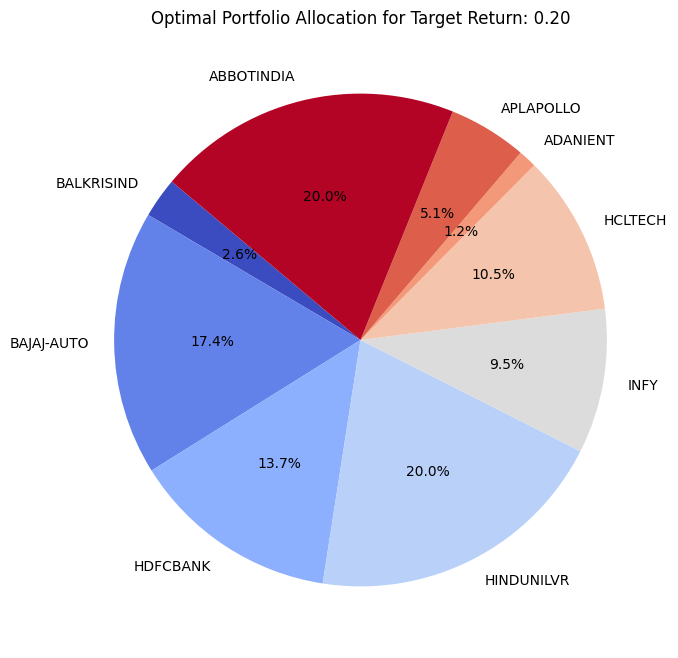

In [6]:
stocks = ['BALKRISIND', 'BAJAJ-AUTO', 'ICICIBANK', 'HDFCBANK', 'HINDUNILVR', 
          'INFY', 'HCLTECH', 'ADANIENT', 'APLAPOLLO', 'ABBOTINDIA']

target_returns = np.linspace(0.20, 0.40, 30)
sector_returns = returns[stocks].dropna(how="any")
mu = (np.exp(sector_returns.mean()) - 1) * 252
Sigma = sector_returns.cov() * 252

# Sector constraints
sector_constraints = {
    "AUTO": 0.20,
    "BANK": 0.20,
    "FMCG": 0.20,
    "IT": 0.20,
    "METAL": 0.20,
    "PHARMA": 0.20,
}

# Sector-wise indices for constraints
sector_indices = {
    sector: [i for i, stock in enumerate(stocks) if sector_map.get(stock) == sector]
    for sector in sector_constraints
}

# Define portfolio weight variable
w = cp.Variable(len(stocks))

# Initialize portfolio optimization variables
optimal_portfolios = []
valid_target_returns = []  # To track target returns with valid solutions

# Base constraints
constraints = [
    cp.sum(w) == 1,  # Sum of weights equals 1
    w >= 0           # No short selling (non-negative weights)
]

# Add sector constraints using masks
for sector, max_weight in sector_constraints.items():
    mask = np.zeros(len(stocks))  # Create mask of zeros
    for i in sector_indices[sector]:  # Set 1 for sector stocks
        mask[i] = 1
    constraints.append(cp.sum(cp.multiply(mask, w)) <= max_weight)

# Iterate over target returns
for R_target in target_returns:
    # Remove old return constraint (if present)
    if len(constraints) > len(sector_constraints) + 2:
        constraints.pop()
    
    # Add new return constraint
    constraints.append(cp.matmul(mu, w) >= R_target)
    
    # Solve the optimization problem
    problem = cp.Problem(cp.Minimize(cp.quad_form(w, Sigma)), constraints)
    problem.solve(solver=cp.SCS)
    
    # Check if the solution is valid
    if problem.status == "optimal":
        optimal_portfolios.append(w.value)
        valid_target_returns.append(R_target)

# Convert results into a DataFrame
df_optimal = pd.DataFrame(optimal_portfolios, columns=stocks, index=valid_target_returns)

# Plot the efficient frontier
portfolio_risks = [np.sqrt(np.dot(np.dot(w.T, Sigma.values), w)) for w in optimal_portfolios]

plt.figure(figsize=(10, 6))
plt.plot(portfolio_risks, valid_target_returns, marker='o', label="Efficient Frontier")
plt.xlabel("Portfolio Risk (Standard Deviation)")
plt.ylabel("Expected Return")
plt.title("Mean-Variance Efficient Frontier with Sector Constraints")
plt.legend()
plt.grid()
plt.show()

# Show pie chart for optimal allocation at specific target return
target_return_index = 0
optimal_weights = df_optimal.iloc[target_return_index]
optimal_weights = optimal_weights[optimal_weights > 0.01]  # Filter small allocations

print("Optimal Portfolio for 20% target return: ")
for stock, weight in optimal_weights.items():
    print(f"{stock}: {weight:.4f}")

plt.figure(figsize=(8, 8))
plt.pie(
    optimal_weights,
    labels=optimal_weights.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.get_cmap("coolwarm")(np.linspace(0, 1, len(optimal_weights))),
)
plt.title(f"Optimal Portfolio Allocation for Target Return: {df_optimal.index[target_return_index]:.2f}")
plt.show()
